In [78]:
import os
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.neighbors import KDTree
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [79]:
def radec_to_unit(ra, dec):
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    return np.vstack([
        np.cos(dec)*np.cos(ra),
        np.cos(dec)*np.sin(ra),
        np.sin(dec)
    ]).T

def angular_sep(v1, v2):
    return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

# def estimate_rotation(A, B):
#     H = A.T @ B
#     U, _, Vt = np.linalg.svd(H)
#     return U @ Vt

def estimate_rotation(A, B):
    H = A.T @ B
    U, _, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt
    return R


In [80]:
SENSORS = [
    {
        "name": "sensor1",
        "centroid_file": "metadata/centroid_files/star_centroids_1.csv",
        "RA": 214.958,
        "DEC": -47.909,
        "FoV_x": 2.030,
        "FoV_y": 1.409,
        "IMG_W": 6576,
        "IMG_H": 4384,
        "FOCAL_MM": 9800,
        "PIXEL_PITCH_UM": 5.5
    },
    {
        "name": "sensor2",
        "centroid_file": "metadata/centroid_files/star_centroids_2.csv",
        "RA": 101.812,
        "DEC": -48.565,
        "FoV_x": 0.429,
        "FoV_y": 0.429,
        "IMG_W": 1024,
        "IMG_H": 1024,
        "FOCAL_MM": 4912,
        "PIXEL_PITCH_UM": 3.6
    },
    {
        "name": "sensor3",
        "centroid_file": "metadata/centroid_files/star_centroids_3.csv",
        "RA": 17.2838,
        "DEC": 13.532,
        "FoV_x": 6.732,
        "FoV_y": 4.789,
        "IMG_W": 13400,
        "IMG_H": 9528,
        "FOCAL_MM": 393,
        "PIXEL_PITCH_UM": 3.45
    },

]

In [81]:
MAG_LIMIT = 9.0

for sensor in SENSORS[1:2]:

    print(f"\n==============================")
    print(f"Processing {sensor['name']}")
    print(f"==============================")

    # ---------- A1: Catalog Download ----------
    search_radius = 0.5 * np.sqrt(sensor["FoV_x"]**2 + sensor["FoV_y"]**2) + 1.0

    center = SkyCoord(
        ra=sensor["RA"]*u.deg,
        dec=sensor["DEC"]*u.deg,
        frame="icrs"
    )

    query = f"""
    SELECT ra, dec, phot_g_mean_mag
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
      POINT('ICRS', ra, dec),
      CIRCLE('ICRS', {sensor["RA"]}, {sensor["DEC"]}, {search_radius})
    )=1
    AND phot_g_mean_mag < {MAG_LIMIT}
    """

    catalog = Gaia.launch_job(query).get_results().to_pandas()
    catalog.to_csv(f"output/{sensor['name']}_catalog.csv", index=False)

    catalog = catalog.sort_values("phot_g_mean_mag").head(80)

    cat_vecs = radec_to_unit(catalog["ra"], catalog["dec"])

    # ---------- A2: Catalog Patterns ----------
    cat_features, cat_triplets = [], []

    for i, j, k in combinations(range(len(cat_vecs)), 3):
        d = sorted([
            angular_sep(cat_vecs[i], cat_vecs[j]),
            angular_sep(cat_vecs[j], cat_vecs[k]),
            angular_sep(cat_vecs[i], cat_vecs[k])
        ])
        cat_features.append([d[0]/d[2], d[1]/d[2]])
        cat_triplets.append((i, j, k))

    cat_tree = KDTree(cat_features)

    # ---------- A3: Centroid Patterns ----------
    centroids = pd.read_csv(sensor["centroid_file"])

    x = centroids["x_centroid"].values
    y = centroids["y_centroid"].values
    brightness = centroids["brightness"].values

    MAX_STARS = 40   # try 30–50

    bright_idx = np.argsort(brightness)[-MAX_STARS:]
    
    x = x[bright_idx]
    y = y[bright_idx]
    brightness = brightness[bright_idx]
    
    cx = sensor["IMG_W"] / 2
    cy = sensor["IMG_H"] / 2
    p_mm = sensor["PIXEL_PITCH_UM"] * 1e-3

    x_mm = (x - cx) * p_mm
    y_mm = (y - cy) * p_mm

    img_rays = np.vstack([
        x_mm,
        y_mm,
        np.full_like(x_mm, sensor["FOCAL_MM"])
    ]).T
    img_rays /= np.linalg.norm(img_rays, axis=1, keepdims=True)

    img_features, img_triplets = [], []

    
    # bright_idx = np.argsort(brightness)[-15:]
    for i, j, k in combinations(range(min(len(img_rays),40)), 3):
    # for i, j, k in combinations(bright_idx, 3):
        d = sorted([
            angular_sep(img_rays[i], img_rays[j]),
            angular_sep(img_rays[j], img_rays[k]),
            angular_sep(img_rays[i], img_rays[k])
        ])
        img_features.append([d[0]/d[2], d[1]/d[2]])
        img_triplets.append((i, j, k))

    # ---------- A3: Matching ----------
    matches = []
    for idx, f in enumerate(img_features):
        dist, ind = cat_tree.query([f], k=1)
        if dist[0][0] < 0.01:
            matches.append((img_triplets[idx], cat_triplets[ind[0][0]]))

    print("Triangle matches found:", len(matches))

    # ---------- A4: Verification ----------
    img_idx, cat_idx = [], []

    from collections import Counter, defaultdict

    vote_table = defaultdict(list)
    
    for img_tri, cat_tri in matches:
        for i in img_tri:
            for j in cat_tri:
                vote_table[i].append(j)

    print("Vote table size:", len(vote_table))

    for i, js in vote_table.items():
        best_j = Counter(js).most_common(1)[0][0]
        img_idx.append(i)
        cat_idx.append(best_j)
    
    img_idx = np.array(img_idx, dtype=int)
    cat_idx = np.array(cat_idx, dtype=int)

    

    # print("img_idx dtype:", img_idx.dtype, len(img_idx), len(np.unique(img_idx)))
    # print("cat_idx dtype:", cat_idx.dtype, len(cat_idx), len(np.unique(cat_idx)))
    print("Number of correspondences:", len(img_idx))


    R = estimate_rotation(img_rays[img_idx], cat_vecs[cat_idx])
    print("Rotation matrix:\n", R)
    print("Determinant:", np.linalg.det(R))

    proj = img_rays @ R
    errors = np.arccos(np.sum(proj[img_idx] * cat_vecs[cat_idx], axis=1))
    errors_deg = np.rad2deg(errors)

    # print("Angular error stats (deg):")
    # print("min :", errors_deg.min())
    # print("mean:", errors_deg.mean())
    # print("max :", errors_deg.max())
    # inliers = errors < np.deg2rad(0.1)
    ANG_TOL = np.deg2rad(3.0)  # 0.5 degrees
    inliers = errors < ANG_TOL

    print(f"Verified matches: {np.sum(inliers)}")

    # ---------- A5: Save Output ----------
    output = pd.DataFrame({
        "x_centroid": x[img_idx[inliers]],
        "y_centroid": y[img_idx[inliers]],
        "brightness": brightness[img_idx[inliers]],
        "RA": catalog["ra"].values[cat_idx[inliers]],
        "DEC": catalog["dec"].values[cat_idx[inliers]],
        "magnitude": catalog["phot_g_mean_mag"].values[cat_idx[inliers]]
    })
    os.makedirs('output_2', exist_ok = True)

    output.to_csv(f"output_2/{sensor['name']}_matched_limited.csv", index=False)
    # break



Processing sensor2
Triangle matches found: 9299
Vote table size: 40
Number of correspondences: 40
Rotation matrix:
 [[ 0.26728767  0.74671206  0.60907996]
 [ 0.95401315 -0.11604295 -0.27639273]
 [-0.13570635  0.65494666 -0.74338998]]
Determinant: 1.000000000000001
Verified matches: 40


# Plots

In [17]:
plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray'
})

# A1 Plot: Star Catalog in Sky Coordinates

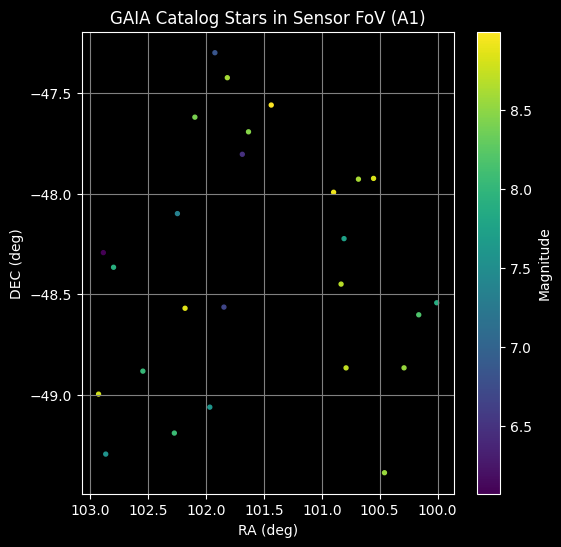

In [70]:
plt.figure(figsize=(6,6))
plt.scatter(
    catalog["ra"], catalog["dec"],
    s=8,
    c=catalog["phot_g_mean_mag"],
    cmap="viridis"
)
plt.gca().invert_xaxis()
plt.colorbar(label="Magnitude")
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("GAIA Catalog Stars in Sensor FoV (A1)")
plt.grid(True)
os.makedirs('output_1', exist_ok = True)
plt.savefig(f"output_2/A1_catalog_sky_{sensor['name']}.png", dpi=150)
plt.show()

# Plot: Catalog Triangle Feature Space

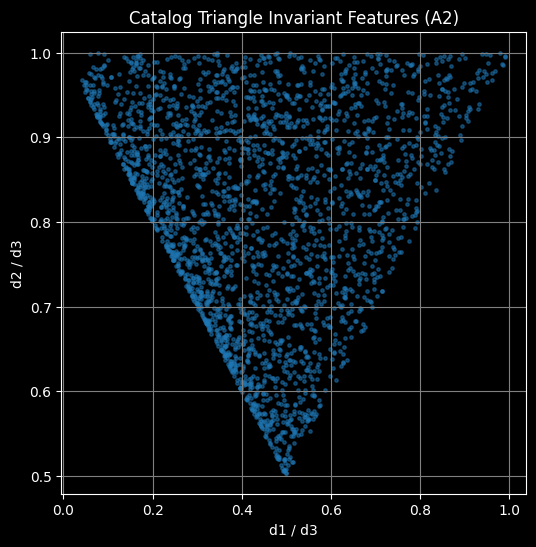

In [71]:
plt.figure(figsize=(6,6))
plt.scatter(
    np.array(cat_features)[:,0],
    np.array(cat_features)[:,1],
    s=6, alpha=0.5
)
plt.xlabel("d1 / d3")
plt.ylabel("d2 / d3")
plt.title("Catalog Triangle Invariant Features (A2)")
plt.grid(True)
plt.savefig(f"output_2/A2_catalog_features_{sensor['name']}.png", dpi=150)
plt.show()

# A3 Plot: Image Centroids & Image Triangle Features

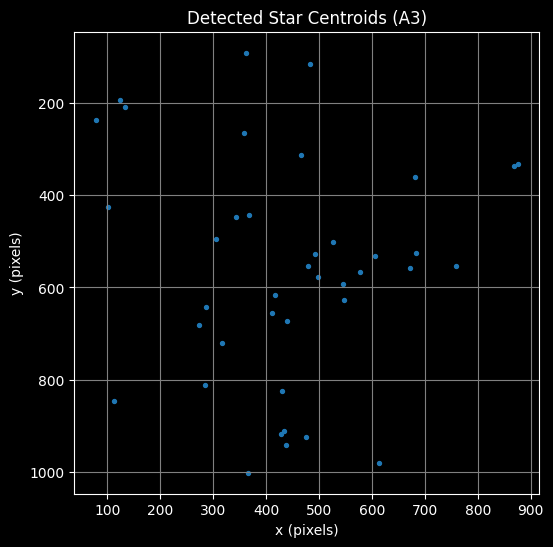

In [72]:
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=8)
plt.gca().invert_yaxis()
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title("Detected Star Centroids (A3)")
plt.grid(True)
plt.savefig(f"output_2/A3_centroids_{sensor['name']}.png", dpi=150)
plt.show()

# Plot: Verified Star Matches & Error Metrics

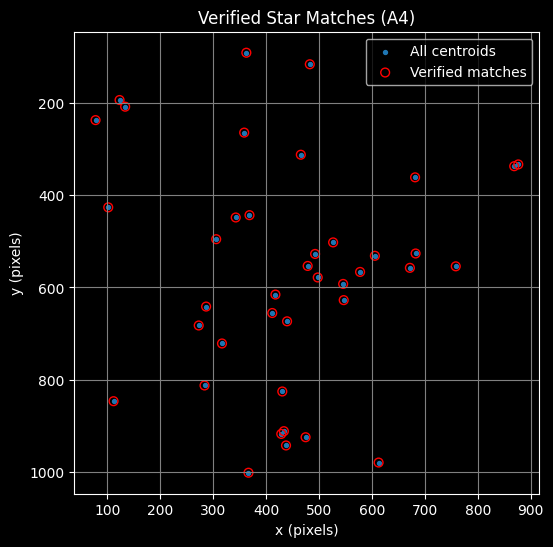

In [73]:
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=8, label="All centroids")
plt.scatter(
    x[img_idx[inliers]],
    y[img_idx[inliers]],
    s=40, edgecolors="r", facecolors="none",
    label="Verified matches"
)
plt.gca().invert_yaxis()
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.legend()
plt.title("Verified Star Matches (A4)")
plt.grid(True)
plt.savefig(f"output_2/A4_verified_matches_{sensor['name']}.png", dpi=150)
plt.show()


In [77]:
# plt.figure(figsize=(6,6))
# plt.scatter(
#     cat_vecs[cat_idx[inliers]][:,0],
#     cat_vecs[cat_idx[inliers]][:,1],
#     label="Catalog stars", s=40
# )
# plt.scatter(
#     (img_rays @ R)[img_idx[inliers]][:,0],
#     (img_rays @ R)[img_idx[inliers]][:,1],
#     marker='x', label="Projected image rays", s=40
# )
# plt.legend()
# plt.title("Catalog vs Projected Image Rays (A4)")
# plt.grid(True)
# plt.savefig(f"output_2/A4_projection_alignment_{sensor['name']}.png", dpi=150)
# plt.show()

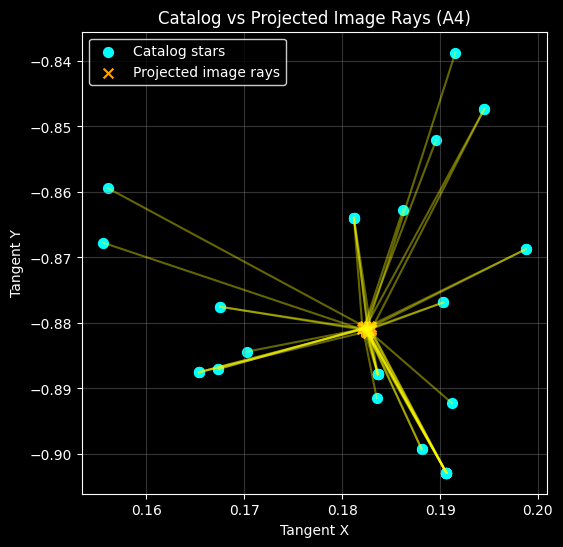

Angular error stats (deg):
min : 0.21529609397887117
mean: 0.6811342617118749
max : 1.4867953683240474


In [75]:
# 1. Select inlier rays
cat = cat_vecs[cat_idx[inliers]]
img = img_rays[img_idx[inliers]]

# 2. Normalize (IMPORTANT)
cat = cat / np.linalg.norm(cat, axis=1, keepdims=True)
img = img / np.linalg.norm(img, axis=1, keepdims=True)

# 3. Rotate image rays to sky frame
img_proj = img @ R  # or R @ img.T depending on your convention

# 4. Project both onto tangent plane (x/z, y/z)
cat_xy = cat[:, :2] / cat[:, 2:3]
img_xy = img_proj[:, :2] / img_proj[:, 2:3]

# 5. Plot
fig, ax = plt.subplots(figsize=(6,6), facecolor='black')
ax.set_facecolor('black')

ax.scatter(
    cat_xy[:,0], cat_xy[:,1],
    s=50, c='cyan', label="Catalog stars"
)

ax.scatter(
    img_xy[:,0], img_xy[:,1],
    s=50, marker='x', c='orange',
    label="Projected image rays"
)
for i in range(len(cat_xy)):
    ax.plot(
        [cat_xy[i,0], img_xy[i,0]],
        [cat_xy[i,1], img_xy[i,1]],
        color='yellow', alpha=0.4
    )

ax.set_xlabel("Tangent X", color='white')
ax.set_ylabel("Tangent Y", color='white')
ax.set_title("Catalog vs Projected Image Rays (A4)", color='white')

ax.tick_params(colors='white')
ax.grid(color='gray', alpha=0.4)
ax.legend(facecolor='black', edgecolor='white', labelcolor='white')

plt.savefig(
    f"output_2/A4_projection_alignment_{sensor['name']}.png",
    dpi=150,
    facecolor=fig.get_facecolor()
)
plt.show()

angular_err = np.degrees(np.arccos(
    np.sum(cat * img_proj, axis=1)
))

print("Angular error stats (deg):")
print("min :", angular_err.min())
print("mean:", angular_err.mean())
print("max :", angular_err.max())


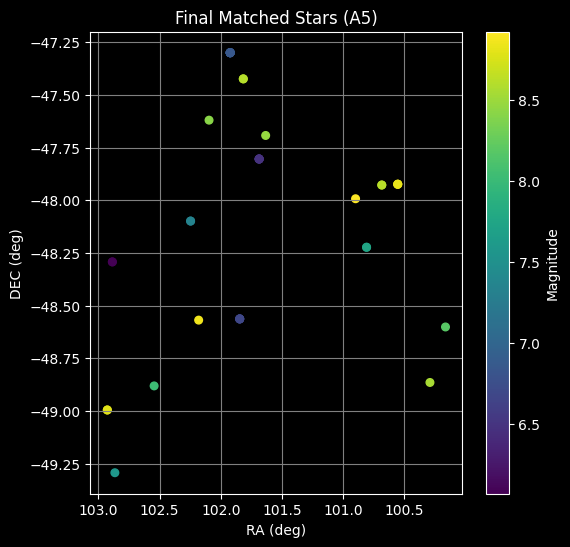

In [76]:
plt.figure(figsize=(6,6))
plt.scatter(
    output["RA"], output["DEC"],
    s=30, c=output["magnitude"], cmap="viridis"
)
plt.gca().invert_xaxis()
plt.colorbar(label="Magnitude")
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("Final Matched Stars (A5)")
plt.grid(True)
plt.savefig(f"output_2/A5_final_matched_stars_{sensor['name']}.png", dpi=150)
plt.show()